# Binomial Option Pricing Model

This project aims to estimate the fair price of American options using binomial option pricing. This model simulates numerous possible future price paths of an underlying asset and calculates the average payoff of the option which is then discounted to determine its price. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import yfinance as yf

from typing import List, Tuple

from data import fetch_data

### Gathering Data

Yahoo Finance was used to fetch all relevant stock data. Apple will be used as an example. Data was fetched over a 2 year period and contains daily records for market data. 

In [3]:
ticker = "AAPL"

fetch_data(ticker)

[*********************100%%**********************]  1 of 1 completed



### Loading and Formatting Data

In [4]:
data = pd.read_csv(f"./data/{ticker}.csv", index_col=0, parse_dates=True)
data.dropna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-23,178.520004,181.550003,178.330002,181.119995,180.197906,52722800
2023-08-24,180.669998,181.100006,176.009995,176.380005,175.482025,54945800
2023-08-25,177.380005,179.149994,175.820007,178.610001,177.700699,51449600
2023-08-28,180.089996,180.589996,178.550003,180.190002,179.272659,43820700
2023-08-29,179.699997,184.899994,179.500000,184.119995,183.182632,53003900
...,...,...,...,...,...,...
2024-08-16,223.919998,226.830002,223.649994,226.050003,226.050003,44340200
2024-08-19,225.720001,225.990005,223.039993,225.889999,225.889999,40687800
2024-08-20,225.770004,227.169998,225.449997,226.509995,226.509995,30299000


### Closing Prices Over Time

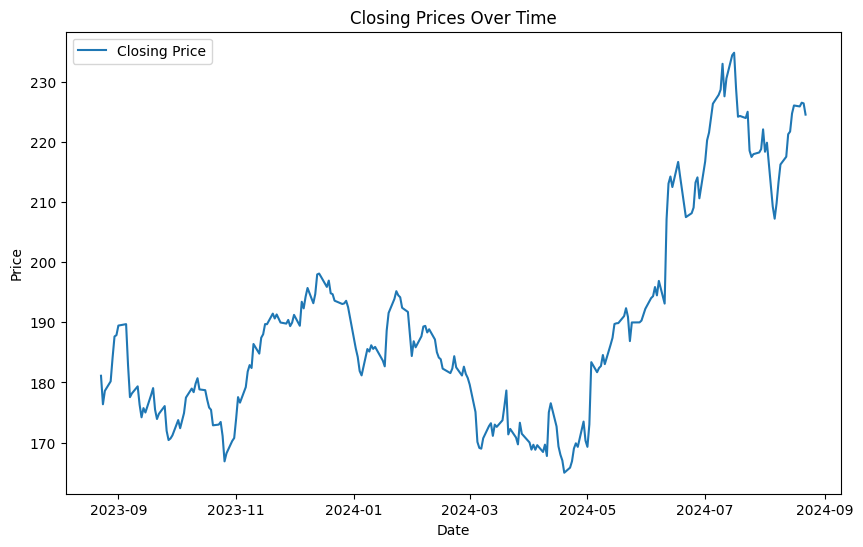

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Closing Price')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Binomial Option Pricing Model Implemenation
#### Parameters
- `S_0` Current stock price
- `option_type` Option type
  - `0` Call
  - `1` Put
- `K` Strike price
- `T` Time to maturity
- `r` Risk-free rate
- `v` Volatility
- `n` Number of steps
  - Increased number of steps provides accuracy at the cost of computation complexity 

In [6]:
S_0 = data["Close"].iloc[-1]
option_type = 0
K = 1.0001 * S_0
T = 1 / 52

### Risk-free Rate
The risk free-free rate is calculated by finding the yield on a Treasury bond that matches the duration of the option.

In [7]:
r = yf.download("^IRX", period="5d")['Close'].mean() / 100

[*********************100%%**********************]  1 of 1 completed



### Volatility
An option's daily volatility is calculated by taking the standard deviation of the daily returns of an asset.

In [8]:
data["Daily Return"] = data["Close"].pct_change()
data.dropna()

v = data["Daily Return"].std()

### Number of Steps
The number of steps in this model is directly correlated to accuracy. The more steps, the more accurate the model. However, this comes at the cost of computation complexity.

In [9]:
n = 10

### Distribution of Daily Returns


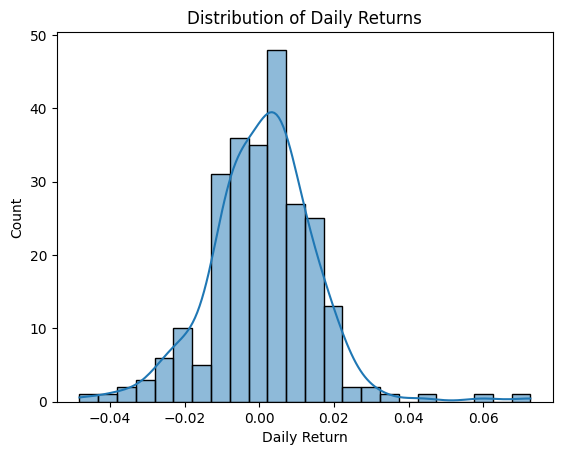

In [10]:
sns.histplot(data['Daily Return'], kde=True)
plt.title("Distribution of Daily Returns")
plt.show()

### BOPM Parameters
#### Up factor `u`
`u` represents the potential increase in the price of the underlying asset during each time step in the model.

$u = e^{\sigma \sqrt{\Delta t}}$

In [11]:
u = np.exp(v * np.sqrt(T / n))


#### Down factor `d`
`d` represents the potential decrease in the price of the underlying asset during each time step in the model.

$d = \frac{1}{u}$

In [12]:
d = 1 / u

#### Risk-neutral probability `p`
`p` represents the probability, in a risk-neutral world, that the stock price will increase in the next step. 

$p = \frac{e^{r \Delta t} - d}{u - d}$

In [13]:
p = (np.exp(r * (T / n)) - d) / (u - d)

## Binomial Tree Implementation
### Stock Price Calculation
Each node of the tree is represented as a tuple (Stock Price, Option Value).

In [14]:
tree: List[List[Tuple[float, float]]] = [[(0, 0) for _ in range(i + 1)] for i in range(n + 1)]
print(S_0, K, T, v, r, n)
tree[0][0] = (S_0, 0)

for i in range(1, n + 1):
    for j in range(i + 1):
        if j == 0:
            tree[i][j] = (tree[i - 1][j][0] * u, 0)
        else:
            tree[i][j] = (tree[i - 1][j - 1][0] * d, 0)

224.52999877929688 224.5524517791748 0.019230769230769232 0.014289229959476213 0.050402000427246095 10


### Option Payoffs at Maturity

In [15]:
for j in range(n + 1):
    if (option_type == 0):
        tree[n][j] = (tree[n][j][0], max(0, tree[n][j][0] - K))
    else:
        tree[n][j] = (tree[n][j][0], max(0, K - tree[n][j][0]))


### Option Value Population

In [16]:
for k in range(n - 1, -1, -1):
    for h in range(k + 1):
        tree[k][h] = (tree[k][h][0], np.exp(-r * (T / n)) * (p * tree[k + 1][h + 1][1] + (1 - p) * tree[k + 1][h][1]))


for l in range(n+1):
    print(tree[l][0][1])

0.08019996068591496
0.12909852020604917
0.2005353491686895
0.2989618303058701
0.42531576082014366
0.5745910571824717
0.7360085199852973
0.8990129706655081
1.0621668970211835
1.2254704232126892
1.3889236735024042


### Conclusions

In [17]:
print(tree[0][0][1])

0.08019996068591496
